In [1]:
import os
import numpy as np
import pandas as pd
from joblib import load
from warnings import filterwarnings

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import (roc_auc_score, roc_curve, RocCurveDisplay, confusion_matrix, 
                            balanced_accuracy_score, f1_score, average_precision_score, precision_score, recall_score)
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, OneHotEncoder, TargetEncoder
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn import set_config

from imblearn.ensemble import EasyEnsembleClassifier, BalancedBaggingClassifier, BalancedRandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
filterwarnings("ignore")

from src.data_transform import *
from src.visuals import *
from src.test_menager import run_test, create_results_dataframe, summarize_results, cv_scores_for_thresholds
from src.utils import load_estimators

In [2]:
file_path = os.path.join("data", "Train_nyOWmfK.csv")
data = pd.read_csv(file_path, encoding = "ISO-8859–1")

In [3]:
data.head(3)

,ID,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,Salary_Account,Mobile_Verified,Var5,Var1,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,LoggedIn,Disbursed
0,ID000002C20,Female,Delhi,20000,23-May-78,15-May-15,300000.0,5.0,0.0,CYBOSOL,HDFC Bank,N,0,HBXX,NaN,NaN,NaN,NaN,NaN,N,Web-browser,G,S122,1,0,0
1,ID000004E40,Male,Mumbai,35000,07-Oct-85,04-May-15,200000.0,2.0,0.0,TATA CONSULTANCY SERVICES LTD (TCS),ICICI Bank,Y,13,HBXA,200000.0,2.0,13.25,NaN,6762.9,N,Web-browser,G,S122,3,0,0
2,ID000007H20,Male,Panchkula,22500,10-Oct-81,19-May-15,600000.0,4.0,0.0,ALCHEMIST HOSPITALS LTD,State Bank of India,Y,0,HBXX,450000.0,4.0,NaN,NaN,NaN,N,Web-browser,B,S143,1,0,0


# Data exploration

The data was collected over a three-month period in 2015.

The dataset includes **26 columns** and **87 020 entries**.


It consists of:
* 13 numerical features
	* 11 continous
    * 2 binary (LoggedIn, **Disbursed - target variable**)
* 13 object-type features


There are 11 features in which missing values occur.

The **ID** column contains unique values for each sample and cannot be used for prediction.
The **LoggedIn** column is for problem understanding purposes and cannot be used for prediction.

The meaning of **Var1**, **Var2**, **Var4**, **Var5** and **Source** is unknown.

### Missing values

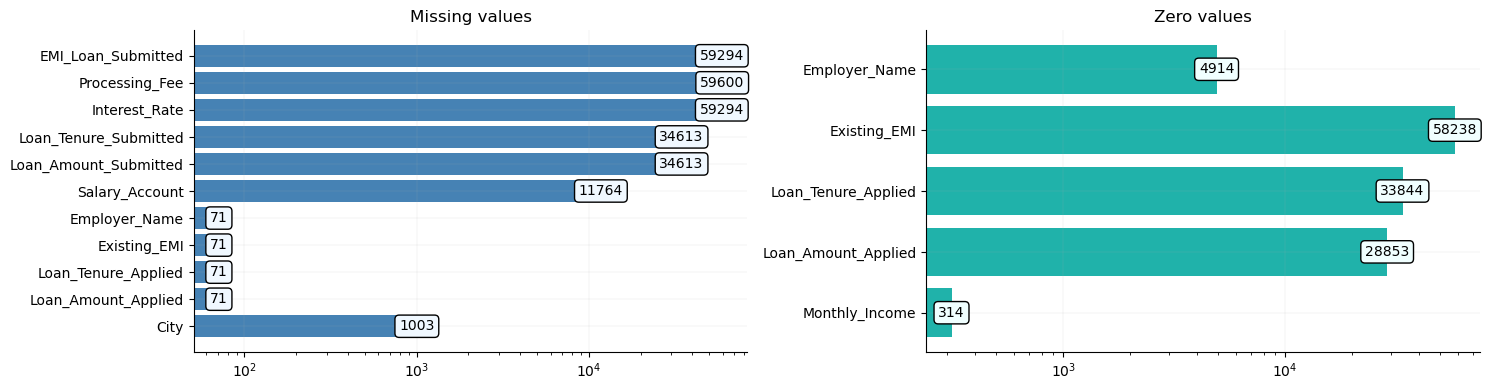

In [4]:
missings_plot(data)

#### There are many NaN and zero values in the dataset. The following assumptions were made:

* At least the majority of missing values are not random.
* **As seen above, there are corresponding missing values in three columns sets**, which may reflect the proccesing of successive stages of the loan apliccation procedure. It's not that all of them had to be completed to receive a loan, although the percentage of disbursements among samples without missing values is higher.
* Numerous zero values in some features can be considered as additional missing values (**Loan_Amount_Applied**, **Loan_Tenure_Applied**, **Employer_Name**).
* Zeros in **Existing_EMI**: no debts.
* Zeros in **Monthly_Income**: lack a steady income.
* The missing values in **City** column may indicate a lack of a permanent place of residence.
* The missing values in **Salary_Account** column may indicate the absence of a bank account, but they could also result from carelessness during filling application.
  

### Categorical variables

In [5]:
data.describe(include = ['O'])

,ID,Gender,City,DOB,Lead_Creation_Date,Employer_Name,Salary_Account,Mobile_Verified,Var1,Filled_Form,Device_Type,Var2,Source
count,87020,87020,86017,87020,87020,86949,75256,87020,87020,87020,87020,87020,87020
unique,87020,2,697,11345,92,43567,57,2,19,2,2,7,30
top,ID000002C20,Male,Delhi,11-Nov-80,03-Jul-15,0,HDFC Bank,Y,HBXX,N,Web-browser,B,S122
freq,1,49848,12527,306,2315,4914,17695,56481,59294,67530,64316,37280,38567


There are 13 categorical features:

* 2 with **dates** (DOB, Lead_Creation_Date)
* 7 categorical with **multiple levels** (ID, City, Employer_Name, Salary_Account, Var1, Var2, Source)
* 4 **binary** categorical (Gender, Mobile_Verified, Filled_Form, Device_Type)

As seen below, multicategorical features have rare values, that can be aggregated in various ways.

In [6]:
data["City"].value_counts().reset_index()

,City,count
0,Delhi,12527
1,Bengaluru,10824
2,Mumbai,10795
3,Hyderabad,7272
4,Chennai,6916
...,...,...
692,Lalitpur,1
693,Kandhamal,1
694,Sawai Madhopur,1
695,Munger,1


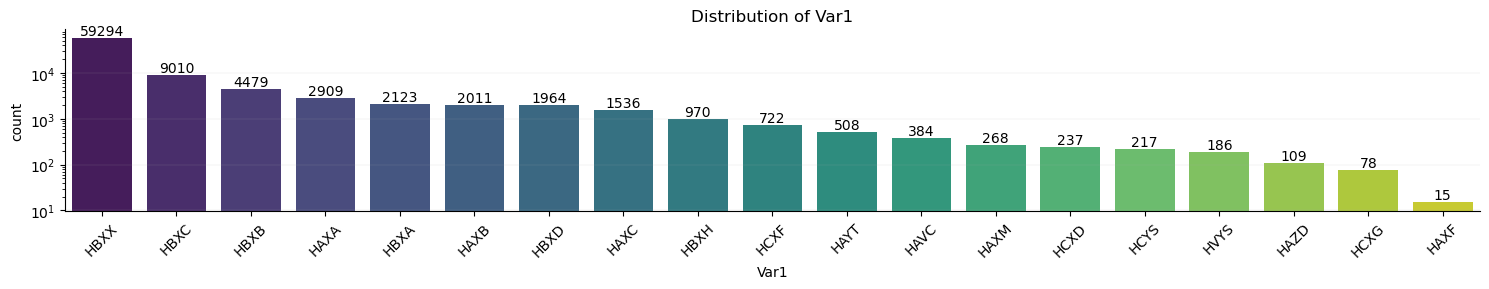

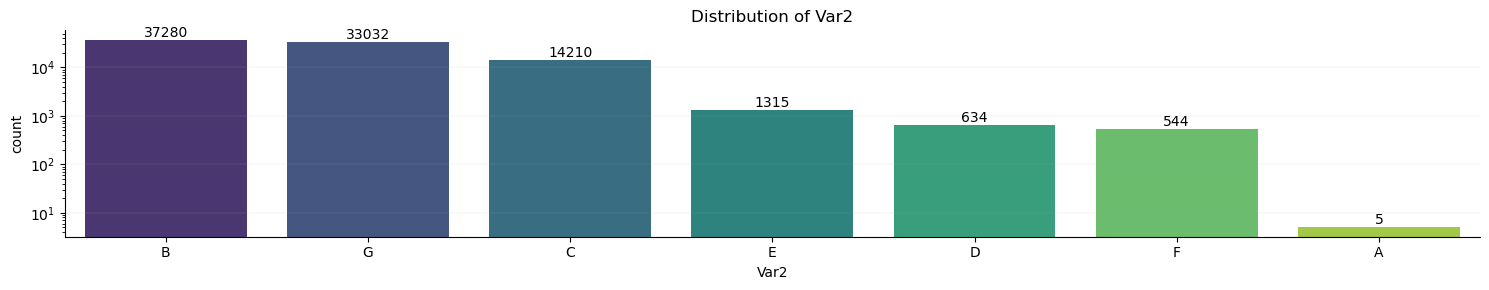

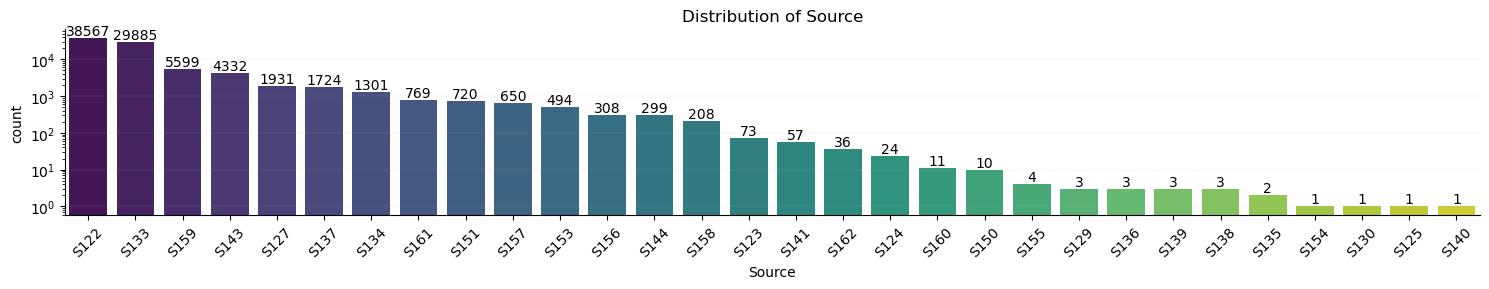

In [7]:
countplots("Var1", "Var2", "Source", data = data)

### Numerical variables

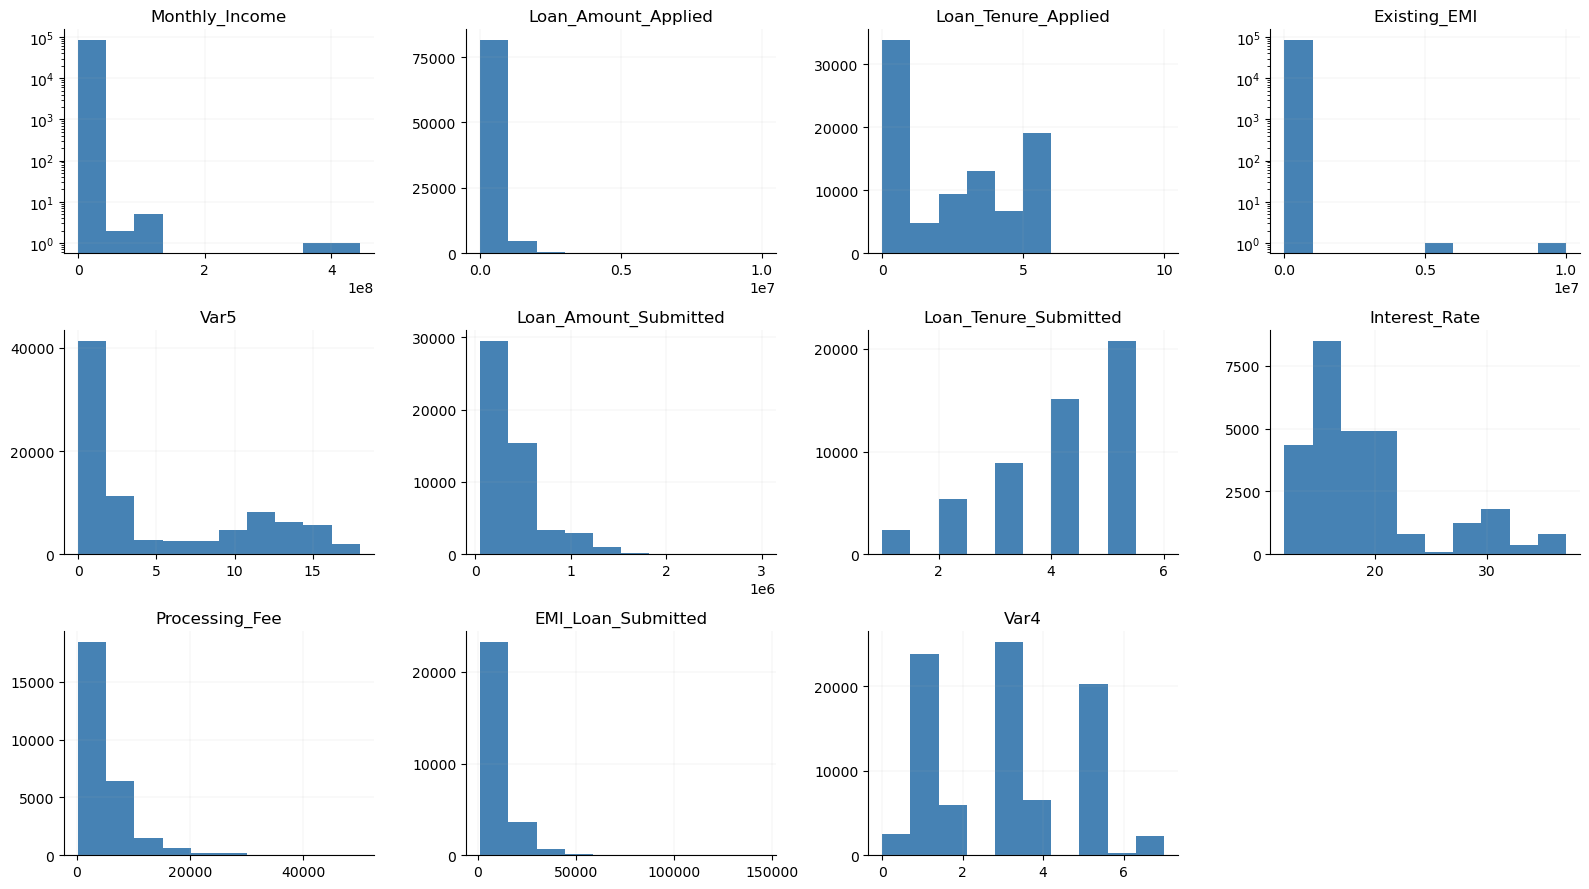

In [8]:
histplots_grid(3, 4, data)

There are 11 continous features.

As seen above, the features display different distributions and varying value ranges. It should be explored the option of applying transformations to bring these values closer to a normal distribution or scale them, especially when using methods that require such transformations. However, these transformations are not necessary when using tree-based algorithms.

### Target variable

In [9]:
data.Disbursed.value_counts(normalize=True).round(4)

Disbursed
0    0.9854
1    0.0146
Name: proportion, dtype: float64

In this dataset, highly imbalanced classes are present. 
The following strategies were adopted to address this issue:

* stratified train_test_split
* stratified KFold for cross-validation
* increasing the weight of the minority class or resampling within balanced ensemble models

# Experiments

## First data version

* **ID**, **Lead_Creation_Date**, **Device_Type**, **Salary_Account** columns removed, since their use in prediction doesn't make logical sense.

* **City** column cransformation: from 698 to 2 categories: Y/N ([cities](https://www.loomsolar.com/blogs/collections/list-of-cities-in-india) with over 1 million residents and smaller), missing values left unchanged. Renamed to **Is_Big_City**. 

* **Employer_Name** column transformation: into 1/0, as it was considered that the employer name is not important, but the fact of providing or not providing this information during the application process may be significant. Renamed to **Employer_Provided**.

* **DOB** column cransformation: from date of birth to year of birth, which is analogous to using age, as the data was collected in the same year. Renamed to **Year_Of_Birth**.

* **Var1, Var2, Source** - rare values aggregated as "Others".

* Numerical variables and missing values left unchanged, except filling 71 corresposponding missings in **Loan_Amount_Applied, Loan_Tenure_Applied, Existing_EMI** with 0.

In [3]:
X, y = data_preparing_v1(data)

X.shape, y.shape

((87020, 20), (87020,))

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    stratify = y,
                                                    random_state = 42)
X_train.head(3)

,Gender,Is_Big_City,Monthly_Income,Year_Of_Birth,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Provided,Mobile_Verified,Var5,Var1,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Var2,Source,Var4
26733,Female,Y,50000,76,1000000.0,5.0,0.0,1,N,15,HBXX,NaN,NaN,NaN,NaN,NaN,N,B,S133,3
81500,Female,Y,17475,88,200000.0,3.0,4732.0,1,N,1,HBXX,NaN,NaN,NaN,NaN,NaN,N,G,S122,3
81659,Female,N,52000,62,0.0,0.0,0.0,1,Y,13,HBXX,1050000.0,5.0,NaN,NaN,NaN,N,G,S122,3


**The main goal of this stage is to track the behavior of models with different types of basic transformations and select the models that achieve the best results.**

Tree-based ensembles were applied:

* BaggingClassifier,
* HistGradientBoostingClassifier,
* RandomForestClassifier,
* BalancedBaggingClassifier with RandomUnderSampler,
* BalancedBaggingClassifier with RandomOverSampler,
* EasyEnsembleClassifier,
* BalancedRandomForestClassifier
 
in their default or slightly modified parameter configurations.

The tests were conducted using **stratified, shuffled 5 fold cross-validation on the training set**.

In [5]:
models = [BaggingClassifier(n_estimators = 100, 
                            random_state = 42, n_jobs = -1),
          BaggingClassifier(estimator = DecisionTreeClassifier(class_weight = {1:100},
                                                               min_samples_leaf = 5,
                                                               random_state = 42),
                            n_estimators = 100,
                            max_samples = 0.5,
                            random_state = 42, n_jobs = -1),
          
          HistGradientBoostingClassifier(random_state = 42),
          HistGradientBoostingClassifier(class_weight = {1:20},
                                         random_state = 42),
          
          RandomForestClassifier(min_samples_leaf = 5,
                                 random_state = 42, n_jobs = -1),
          RandomForestClassifier(class_weight = {1:100}, 
                                 min_samples_leaf = 20,
                                 max_samples = 0.5,
                                 random_state = 42, n_jobs = -1),
          
          BalancedBaggingClassifier(n_estimators = 100,
                                    sampler = RandomUnderSampler(random_state = 42),
                                    random_state = 42, n_jobs = -1),
          BalancedBaggingClassifier(n_estimators = 100,
                                    max_samples = 0.5,
                                    sampler = RandomUnderSampler(random_state = 42),
                                    replacement = True,
                                    random_state = 42, n_jobs = -1),
          
          BalancedBaggingClassifier(n_estimators = 100,
                                    sampler = RandomOverSampler(random_state = 42),
                                    random_state = 42, n_jobs = -1),
          
          EasyEnsembleClassifier(n_estimators = 50, 
                                 random_state = 42, n_jobs = -1),
          EasyEnsembleClassifier(n_estimators = 100,
                                 random_state = 42, n_jobs = -1, 
                                 replacement = True),
          
          BalancedRandomForestClassifier(random_state = 42, n_jobs = -1, 
                                         replacement = True, sampling_strategy="auto"),
          BalancedRandomForestClassifier(max_samples = 0.5,
                                         min_samples_leaf = 10,
                                         random_state = 42, n_jobs = -1, 
                                         replacement = True, sampling_strategy="auto")
         ]

### Missing values imputation tests

In this section, tests were conducted with various methods of handling missing values. The following were tested:

* imputation with an out-of-range value (-1) by **Simple Imputer**,
* **KNN Imputer** (preceded by scaling for better performance),
* experimental **Iterative Imputer** (preceded by power transformation for better performance),
* **the lack of imputation** was checked for models that support it.

**One-hot encoding** was applied to categorical features.

In [14]:
num_preprocessors = [
            ("SimpleImputer",
             SimpleImputer(strategy = "constant", 
                           fill_value = -1)), 
            ("KNNImputer",
             make_pipeline(MinMaxScaler(),
                           KNNImputer())), 
            ("IterativeImputer",
             make_pipeline(PowerTransformer(),
                           IterativeImputer(sample_posterior = True,
                                            random_state = 42))),
            ("none", "passthrough")
]

results_imp = run_test(X_train, y_train,
                       test = "imputation",
                       models = models,
                       preprocessors = num_preprocessors)

In [7]:
# results_imp = pd.read_csv("results_data/data_v1_results_imputation.csv")

results_imp.set_index("Model").sort_values(by = ["ROC_AUC"], ascending = False).head()

,Parameters,ROC_AUC,Imputation,Time[s]
Model,,,,
HistGradientBoostingClassifier,"class_weight: {1: 20}, min_samples_leaf: 20",0.8479,none,1.38
HistGradientBoostingClassifier,"class_weight: {1: 20}, min_samples_leaf: 20",0.8445,IterativeImputer,5.54
HistGradientBoostingClassifier,"class_weight: {1: 20}, min_samples_leaf: 20",0.8438,SimpleImputer,1.60
BalancedBagging_UnderSampling,"n_estimators: 100, max_samples: 0.5",0.8434,SimpleImputer,1.38
BalancedRandomForestClassifier,"n_estimators: 100, class_weight: None, min_samples_leaf: 1, max_samples: None",0.8420,SimpleImputer,1.38


In [8]:
summarize_results(results_imp, column_to_group_by = "Imputation")

,count,mean_roc_auc,min_roc_auc,max_roc_auc,mean_time[s],min_time[s],max_time[s]
Imputation,,,,,,,
none,7,0.825000,0.787100,0.847900,6.640000,1.380000,30.530000
IterativeImputer,13,0.822800,0.766800,0.844500,12.960000,5.540000,46.560000
SimpleImputer,13,0.824800,0.763200,0.843800,7.840000,1.260000,37.220000
KNNImputer,13,0.821700,0.758300,0.841900,286.330000,278.500000,311.970000


There is no significant difference in imputation performance among different imputers, but the execution time for KNNImputer is unacceptable. The best results were achieved by HistGradientBoostingClf without imputation and with Simple Imputer.

### Category encoders tests

In this section, tests were conducted with various methods of encoding categorical features. The following were tested:

* **one-hot encoding**,
* **target encoding**,
* **dropping categorical features**

Missing values in numerical columns were filled with the vallue -1 using Simple Imputer.
For the categorical column Is_Big_City, the missing values are encoded as a separate category.

In [17]:
cat_preprocessors = [
    ("OneHotEncoder", OneHotEncoder()),
    ("TargetEncoder", TargetEncoder(random_state=42)),
    ("dropped", "drop")
]

results_enc = run_test(X_train, y_train,
                       test = "cat_encoding",
                       models = models,
                       preprocessors = cat_preprocessors)

In [9]:
# results_enc = pd.read_csv("results_data/data_v1_results_cat_encoding.csv")

results_enc.set_index("Model").sort_values(by = ["ROC_AUC"], ascending = False).head()

,Parameters,ROC_AUC,Encoder,Time[s]
Model,,,,
HistGradientBoostingClassifier,"class_weight: {1: 20}, min_samples_leaf: 20",0.8447,TargetEncoder,1.05
BalancedRandomForestClassifier,"n_estimators: 100, class_weight: None, min_samples_leaf: 1, max_samples: None",0.8444,TargetEncoder,1.30
HistGradientBoostingClassifier,"class_weight: {1: 20}, min_samples_leaf: 20",0.8438,OneHotEncoder,1.58
BalancedBagging_UnderSampling,"n_estimators: 100, max_samples: 0.5",0.8434,OneHotEncoder,1.39
BalancedBagging_UnderSampling,"n_estimators: 100, max_samples: 0.5",0.8431,TargetEncoder,1.16


In [10]:
summarize_results(results_enc, column_to_group_by = "Encoder")

,count,mean_roc_auc,min_roc_auc,max_roc_auc,mean_time[s],min_time[s],max_time[s]
Encoder,,,,,,,
TargetEncoder,13,0.827500,0.776000,0.844700,5.940000,0.870000,23.010000
OneHotEncoder,13,0.824800,0.763200,0.843800,7.840000,1.290000,37.910000
dropped,13,0.813700,0.736000,0.835900,4.760000,0.570000,21.900000


The method of encoding categorical features did not significantly affect the results, but TargetEncoder gave the best results and was the fastest. Furthermore, excluding categorical features only slightly worsened the results.

### Feature selection tests

While there are only 20 variables, the meaning of 5 of them is unknown, which is why such a test was conducted.

Feature selection based on importance weights was applied.

Missing values in numerical columns were filled with the value -1 using Simple Imputer.
For the categorical columns, Target Encoder were used.

#### Estimator optimization

**Random Forest Classifier** with best found parameters was used as the feature selection estimator.

In [6]:
model = RandomForestClassifier(random_state=42, n_jobs=-1)

param_grid = {"model__class_weight": [{1:75}, {1:100}],
              "model__n_estimators": [100, 200],
              "model__min_samples_leaf": [5, 20, 50],
              "model__max_features": [0.3, 0.5, 0.7],
              "model__max_samples": [0.3, 0.5, 0.7]}

best_score = run_test(X_train, y_train,
                      test = "grid_search",
                      search = (model, param_grid)) # saving estimator: results_data/pickles/fs_forest.pkl
best_score

0.8456

#### Feature selection

In [7]:
best_forest = load("results_data/pickles/fs_forest.pkl")

results_sel = run_test(X_train, y_train,
                       test = "feature_selection",
                       feat_sel_estimator = best_forest,
                       models = models)

In [11]:
# results_sel = pd.read_csv("results_data/data_v1_results_feature_selection.csv")

results_sel.set_index("Model").sort_values(by = ["ROC_AUC"], ascending = False).head()

,Parameters,ROC_AUC,Threshold,Selected[%],Rejected[idx],Time[s]
Model,,,,,,
HistGradientBoostingClassifier,"class_weight: {1: 20}, min_samples_leaf: 20",0.8450,0.0165,85.0,[ 5 8 17],4.18
HistGradientBoostingClassifier,"class_weight: {1: 20}, min_samples_leaf: 20",0.8447,0.0100,100.0,[],4.27
HistGradientBoostingClassifier,"class_weight: {1: 20}, min_samples_leaf: 20",0.8444,0.0150,95.0,[17],4.43
BalancedRandomForestClassifier,"n_estimators: 100, class_weight: None, min_samples_leaf: 1, max_samples: None",0.8444,0.0100,100.0,[],4.85
HistGradientBoostingClassifier,"class_weight: {1: 20}, min_samples_leaf: 20",0.8440,0.0180,65.0,[ 3 5 8 10 13 15 17],4.27


In [12]:
summarize_results(results_sel, column_to_group_by = "Selected[%]")

,count,mean_roc_auc,min_roc_auc,max_roc_auc,mean_time[s],min_time[s],max_time[s]
Selected[%],,,,,,,
85.000000,13,0.826500,0.769000,0.845000,9.060000,4.180000,26.010000
100.000000,13,0.827500,0.776000,0.844700,9.440000,4.150000,27.330000
95.000000,13,0.827500,0.776500,0.844400,9.270000,4.430000,26.120000
65.000000,13,0.826800,0.771200,0.844000,8.750000,4.270000,25.830000
80.000000,13,0.826300,0.766100,0.843600,8.920000,4.070000,25.880000
90.000000,13,0.826600,0.768700,0.843100,9.160000,4.350000,25.960000
60.000000,13,0.823600,0.766400,0.840400,8.360000,4.170000,25.510000
50.000000,13,0.821200,0.761600,0.837800,8.020000,4.060000,25.140000


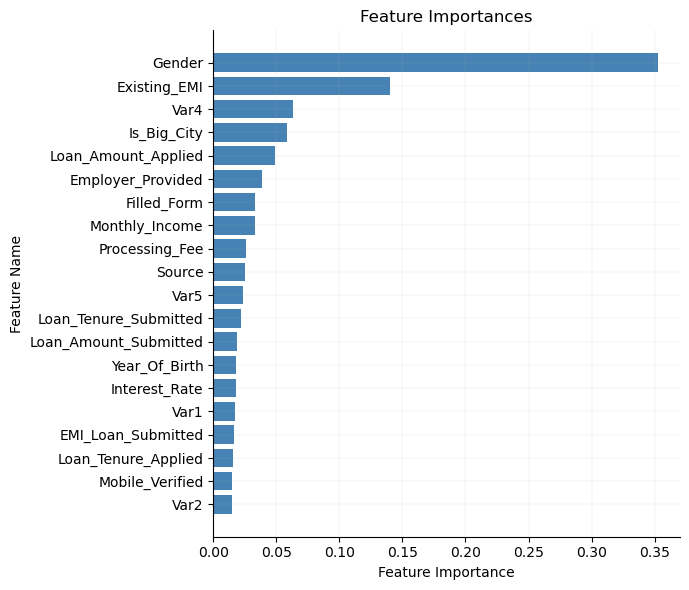

In [10]:
feature_importance_plot(best_forest.feature_importances_, X.columns)

The best results were achieved by retaining 85-100% of the features.

It was determined which features are the least important, and it was found that removing them does not significantly impact the results. Very high scores (above 84) were achieved even when only 60% of the features were selected. So it could also be checked if, after removing some columns, but with different hyperparameters for the models, the results will be better. It could also be tested other transformations of categorical columns, which may allow to extract more information from them.

In [13]:
all_models_results = create_results_dataframe(results_imp[["Model", "ROC_AUC", "Time[s]"]],
                                              results_enc[["Model", "ROC_AUC", "Time[s]"]],
                                              results_sel[["Model", "ROC_AUC", "Time[s]"]])

summarize_results(all_models_results, column_to_group_by = "Model")

,count,mean_roc_auc,min_roc_auc,max_roc_auc,mean_time[s],min_time[s],max_time[s]
Model,,,,,,,
HistGradientBoostingClassifier,30,0.841200,0.831500,0.847900,21.780000,0.570000,280.790000
BalancedRandomForestClassifier,28,0.839100,0.832700,0.844400,23.500000,1.170000,281.250000
BalancedBagging_UnderSampling,30,0.839600,0.830300,0.843400,22.300000,0.990000,281.450000
RandomForestClassifier,28,0.829300,0.810100,0.842200,23.570000,1.050000,280.630000
EasyEnsembleClassifier,28,0.830400,0.821600,0.832600,39.940000,11.070000,305.410000
BaggingClassifier,30,0.795800,0.756000,0.826200,25.450000,2.700000,285.290000
BalancedBagging_OverSampling,15,0.769600,0.736000,0.787100,45.380000,13.650000,311.970000


**A summary of all tests from this phase for the models** can be seen in the table above. For further testing, HistGradientBoostingClf, BalancedRandomForestClf, BalancedBaggingClf with undersampling, RandomForestClf were chosen, as they consistently provided the highest ROC_AUC scores in all tests, and were also the fastest. The worst results were achieved by BalancedBaggingClf with oversampling.

## Different data transformations and hyperparameters optimization

At this stage, we revert to raw data, and all transformations will be performed solely using transformers within pipelines (only insignificant columns were removed). The aim is to find the most advantageous data transformation and best hyperparameters.

In [15]:
X, y = data_preparing_v2(data)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    stratify = y,
                                                    random_state = 42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((69616, 20), (69616,), (17404, 20), (17404,))

In [16]:
X_train.head(3)

,Gender,City,Monthly_Income,DOB,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,Mobile_Verified,Var5,Var1,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Var2,Source,Var4
26733,Female,Delhi,50000,02-Apr-76,1000000.0,5.0,0.0,SCHOLASTIC INDIA PVT LTD,N,15,HBXX,NaN,NaN,NaN,NaN,NaN,N,B,S133,3
81500,Female,Chennai,17475,19-Jun-88,200000.0,3.0,4732.0,PRACTO TECHNOLOGIES PVT LTD,N,1,HBXX,NaN,NaN,NaN,NaN,NaN,N,G,S122,3
81659,Female,Noida,52000,15-Mar-62,0.0,0.0,0.0,NEW OKHLA INDUSTRIAL DEVELOPMENT AUTHORITY,Y,13,HBXX,1050000.0,5.0,NaN,NaN,NaN,N,G,S122,3


In [17]:
set_config(transform_output="pandas")

feature_union = FeatureUnion([
    
    ("cat_pipe", Pipeline([
        ("aggreg", ColumnTransformer([
            ("city", RareAggregator(), ["City"]),
            ("vars", RareAggregator(), ["Var1", "Var2", "Source"]),
            ("specials", "drop", ["DOB", "Employer_Name"])
        ], remainder="passthrough")),
        ("encoder", TargetEncoder(random_state=42))])),
    
    ("specials", ColumnTransformer([
        ("zero_one", ZeroOneEncoder(), ["Employer_Name"]),
        ("date", DateEncoder(), "DOB")]))
])

num_pipe = Pipeline([
    ("imputer", MixedImputer()), 
    ("power_tran", PowerTransformer())
])

preprocessor = ColumnTransformer([
    ("num_pipe", num_pipe, selector(dtype_include="number")),
    ("cat_union", feature_union, selector(dtype_include="object"))
])

# final_pipeline = Pipeline([("preprocessor", preprocessor), 
#                            ("remover", ColumnRemover()), 
                           # ("model", model)])

In [18]:
preprocessor.fit_transform(X_train, y_train).head(3)

,num_pipe__Monthly_Income,num_pipe__Loan_Amount_Applied,num_pipe__Loan_Tenure_Applied,num_pipe__Existing_EMI,num_pipe__Var5,num_pipe__Loan_Amount_Submitted,num_pipe__Loan_Tenure_Submitted,num_pipe__Interest_Rate,num_pipe__Processing_Fee,num_pipe__EMI_Loan_Submitted,num_pipe__Var4,cat_union__city__City,cat_union__vars__Var1,cat_union__vars__Var2,cat_union__vars__Source,cat_union__remainder__Gender,cat_union__remainder__Mobile_Verified,cat_union__remainder__Filled_Form,cat_union__zero_one__Employer_Name,cat_union__date__DOB
26733,0.736105,1.217608,1.238392,-0.699601,1.348800,-1.216913,-1.178071,-0.682279,-0.676517,-0.682437,0.13088,0.022190,0.011458,0.016601,0.017119,0.008583,0.007866,0.012267,1,39
81500,-0.478831,0.605921,0.627402,1.410446,-0.445116,-1.216913,-1.178071,-0.682279,-0.676517,-0.682437,0.13088,0.009010,0.011458,0.013576,0.014639,0.008583,0.007866,0.012267,1,26
81659,0.784759,-1.374585,-1.150072,-0.699601,1.248332,1.143368,1.121261,-0.682279,-0.676517,-0.682437,0.13088,0.010868,0.011458,0.013576,0.014639,0.008583,0.018275,0.012267,1,53


In [16]:
models = [HistGradientBoostingClassifier(random_state = 42),
          BalancedRandomForestClassifier(random_state = 42, n_jobs = -1, 
                                         sampling_strategy = "auto"),
          BalancedBaggingClassifier(random_state = 42, n_jobs = -1),
          RandomForestClassifier(random_state = 42, n_jobs = -1)]

param_grids = [{"model__class_weight": [{1:20}, {1:50}, None],
                "model__min_samples_leaf": [20, 50, 100],
                "preprocessor__cat_union__cat_pipe__aggreg__city__threshold": [500, 1000, 2000],
                "preprocessor__cat_union__cat_pipe__aggreg__vars__threshold": [600, 1000, 1500],
                "preprocessor__num_pipe__imputer__how": ["simple", "applied_submitted_compression", None],
                "preprocessor__num_pipe__power_tran": [PowerTransformer(), "passthrough"],
                "remover__to_drop": [0, 1, 2, 3, 4, 5, 6]},
               
               {"model__n_estimators": [100, 200],
                "model__min_samples_leaf": [1, 20],
                "model__max_features": [0.3, 0.6, 1.0],
                "model__max_samples": [0.3, 0.6, 1.0],
                "model__replacement": [True, False],
                "preprocessor__cat_union__cat_pipe__aggreg__city__threshold": [500, 1000, 2000],
                "preprocessor__cat_union__cat_pipe__aggreg__vars__threshold": [600, 1000, 1500],
                "preprocessor__num_pipe__imputer__how": ["simple", "applied_submitted_compression"],
                "preprocessor__num_pipe__power_tran": [PowerTransformer(), "passthrough"],
                "remover__to_drop": [0, 1, 2, 3, 4, 5, 6]},
               
               {"model__n_estimators": [100, 200],
                "model__max_features": [0.5, 1.0],
                "model__max_samples": [0.5, 1.0],
                "model__replacement": [True, False],
                "preprocessor__cat_union__cat_pipe__aggreg__city__threshold": [500, 1000, 2000],
                "preprocessor__cat_union__cat_pipe__aggreg__vars__threshold": [600, 1000, 1500],
                "preprocessor__num_pipe__imputer__how": ["simple", "applied_submitted_compression", None],
                "preprocessor__num_pipe__power_tran": [PowerTransformer(), "passthrough"],
                "remover__to_drop": [0, 1, 2, 3, 4, 5, 6]},
               
               {"model__class_weight": [{1:75}, {1:100}, "balanced"],
                "model__n_estimators": [100, 200],
                "model__min_samples_leaf": [1, 20, 50],
                "model__max_features": [0.3, 0.6, 0.9],
                "model__max_samples": [0.3, 0.6, 0.9],
                "preprocessor__cat_union__cat_pipe__aggreg__city__threshold": [500, 1000, 2000],
                "preprocessor__cat_union__cat_pipe__aggreg__vars__threshold": [600, 1000, 1500],
                "preprocessor__num_pipe__imputer__how": ["simple", "applied_submitted_compression"],
                "preprocessor__num_pipe__power_tran": [PowerTransformer(), "passthrough"],
                "remover__to_drop": [0, 1, 2, 3, 4, 5, 6]}
              ]

results = run_test(X_train, y_train,
                   test = "randomized_search",
                   preprocessors = [preprocessor, ColumnRemover()],
                   search = (models, param_grids))
                    # saving in results_data: pickles/model_name.pkl (best estimator), best_estimators.csv (results)
results

,Model,ROC_AUC,Time[s]
0,HistGradientBoostingClassifier,0.8497,5.59
1,BalancedRandomForestClassifier,0.8487,9.46
2,BalancedBaggingClassifier,0.8468,12.20
3,RandomForestClassifier,0.8466,11.76


### Searching for the optimal classification thresholds

In this task, the goal is not classification, and its threshold may be determined based on various business factors. However, as a reference point, the optimal classification threshold can be defined. An optimal threshold can be considered one where there is the highest true positive rate, while keeping the false positive rate as low as possible. It can be determined using highest geometric mean of TPR and FPR.

In [19]:
HGBclf, BRFclf, BBclf, RFclf = load_estimators()

estimators = [
    ("HistGradientBoostingClf", HGBclf),
    ("BalancedRandomForestClf", BRFclf),
    ("BalancedBaggingClf", BBclf),
    ("RandomForestClf", RFclf)
]

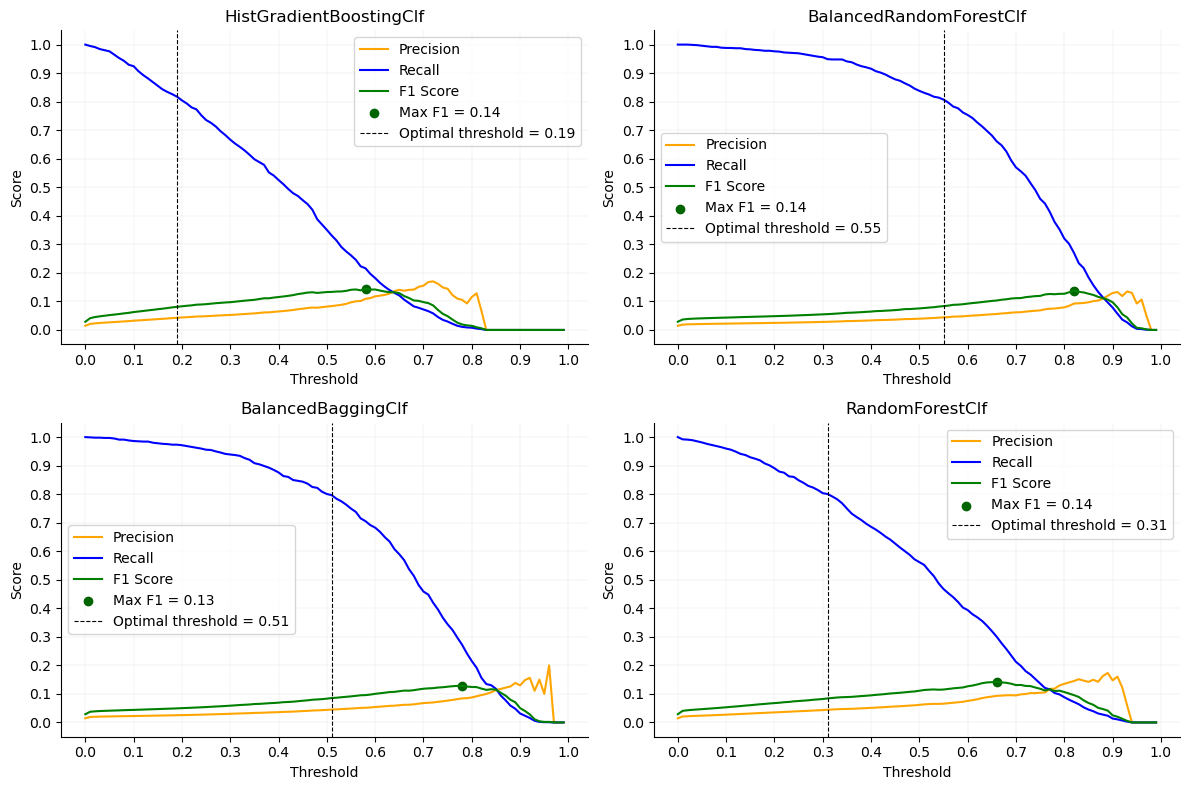

In [12]:
thresholds = np.arange(0, 1, 0.01)

_, optimal_thresholds = cv_scores_for_thresholds(estimators, 
                                                 X_train, y_train, 
                                                 thresholds)

# Models evaluation on test data